# **Problem Statement**
The objective of this task is to detect negative reviews in the dataset. Formally, given a training sample of reviews and labels, where label ‘1’ denotes the review is **negative** and label ‘0’ denotes the tweet is **positive or neutral**.





# **1.1** importing dataset from Kaggle to google Colab

---


I am the using dataset of **Amazon fine food reviews** which is avaliable on kaggle for this project. 


In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shikharkatiyar","key":"5099855dfb4762e0dfc1755f05bdda20"}'}

In [3]:
! rm -rf ~/.kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download -d snap/amazon-fine-food-reviews

100% 242M/242M [00:03<00:00, 84.7MB/s]
100% 242M/242M [00:03<00:00, 82.3MB/s]


In [6]:
!unzip amazon-fine-food-reviews.zip -d amazon-fine-food-reviews

Archive:  amazon-fine-food-reviews.zip
  inflating: amazon-fine-food-reviews/Reviews.csv  
  inflating: amazon-fine-food-reviews/database.sqlite  
  inflating: amazon-fine-food-reviews/hashes.txt  


# **1.2**  Data Preprocessing

---


  Importing Libraries and tools

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
import re
import os
from bs4 import BeautifulSoup
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
import xgboost, textblob, string
from tensorflow.keras.preprocessing import text, sequence
%matplotlib inline

In [8]:
data = pd.read_csv("/content/amazon-fine-food-reviews/Reviews.csv",nrows=50000)
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Attributes

*   **Id:**	Row Id		
*   **ProductId:** Unique identifier for the product
*   **UserId:** Unqiue identifier for the user
*   **ProfileName:** Profile name of the user
*   **HelpfulnessNumerator:** Number of users who found the review helpful
*   **HelpfulnessDenominator:** Number of users who indicated whether they found the review helpful or not
*   **Score:** Rating between 1 and 5
*   **Time:** Timestamp for the review
*   **Summary:** Brief summary of the review
*   **Text:** Text of the review

---


for the given problem we need columns:
1.   *Score*
2.   *Summary*
3.   *Text*





In [9]:
data.drop(['Id','ProductId','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator','Time'], axis=1, inplace=True)
data.head()

,Score,Summary,Text
0,5,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,4,"""Delight"" says it all",This is a confection that has been around a fe...
3,2,Cough Medicine,If you are looking for the secret ingredient i...
4,5,Great taffy,Great taffy at a great price. There was a wid...


dropping duplicates and null values

In [10]:
data.drop_duplicates(subset=['Text'],inplace=True)  
data.dropna(axis=0,inplace=True)
data.describe()

,Score
count,46253.000000
mean,4.143580
std,1.325949
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


# **1.3** Data Cleaning
We will perform these below tasks for our data:

* Contraction mapping
* Convert everything to lowercase
* Remove HTML tags
* Remove (‘s)
* Remove any text inside the parenthesis ( )
* Eliminate punctuations and special characters
* Remove stopwords
* Remove short words


In [11]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}


In [12]:
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [13]:
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [14]:
cleaned_text = []
for text in data['Text']:
    cleaned_text.append(text_cleaner(text))
cleaned_summary = []
for text in data['Summary']:
    cleaned_summary.append(text_cleaner(text))

In [15]:
data['Text']=cleaned_text
data['Summary']=cleaned_summary
data['Summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)
data.head()

,Score,Summary,Text
0,5,good quality dog food,bought several vitality canned dog food produc...
1,1,advertised,product arrived labeled jumbo salted peanuts p...
2,4,delight says,confection around centuries light pillowy citr...
3,2,cough medicine,looking secret ingredient robitussin believe f...
4,5,great taffy,great taffy great price wide assortment yummy ...


# **2. Generate Target (Y)**
Raw dataset doesn't have any 0's and 1's from which we can classify a review as positive or negative. But dataset has provided the star ratings along with reviews.

***Binning:*** Ratings of reviews range from 1 to 5. So, we will group reviews of rating *(1,2) as negative, (3) as neutral and (4,5) as positive*.

***Hot-one Encoding:*** That means target of a **positive** review is [0 0 1] , of a **neutral** is [0 1 0] and of a **negative** is [1 0 0]

In [16]:
score = list(data['Score'])
target_y = np.zeros((len(score), 3))
count = [0]*3
#print(target_y)
for i in range(len(score)):
  if score[i] == 3:
    target_y[i,1] = 1
    count[1] += 1
  elif score[i] > 3:
    target_y[i,2] = 1
    count[2] += 1
  elif score[i] < 3: 
    target_y[i,0] = 1
    count[0] += 1
count

[6891, 3624, 35419]

In [17]:
data['Target'] = list(target_y)
data[:5]

,Score,Summary,Text,Target
0,5,good quality dog food,bought several vitality canned dog food produc...,"[0.0, 0.0, 1.0]"
1,1,advertised,product arrived labeled jumbo salted peanuts p...,"[1.0, 0.0, 0.0]"
2,4,delight says,confection around centuries light pillowy citr...,"[0.0, 0.0, 1.0]"
3,2,cough medicine,looking secret ingredient robitussin believe f...,"[1.0, 0.0, 0.0]"
4,5,great taffy,great taffy great price wide assortment yummy ...,"[0.0, 0.0, 1.0]"


# **3. Data visualization**

In [18]:
from matplotlib import pyplot as plt
def plot(x, y, x_label, y_label, title, type = 'bo'):
  plt.plot(x, y, type)  
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)
  plt.show()

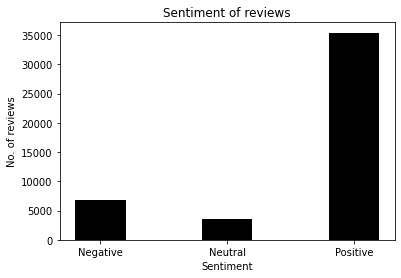

In [19]:
plt.bar(['Negative', 'Neutral', 'Positive'], count, color ='black', width = 0.4) 
plt.xlabel("Sentiment")
plt.ylabel("No. of reviews")
plt.title("Sentiment of reviews")
plt.show()

In [20]:
for i in range(data.shape[0]):
  if count[2] > 25000:
    if score[i] > 3:
      data['Text'][i] = np.nan
      count[2] -= 1
  else:
    break
count

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


[6891, 3624, 25000]

In [21]:
data.dropna(axis=0,inplace=True)
data.shape

(36036, 4)

In [22]:
full_dataset = pd.read_csv("/content/amazon-fine-food-reviews/Reviews.csv")

In [23]:
def generate_y(score):
  x = np.zeros(3)
  if score > 3:
    x[2] = 1
  elif score < 3:
    x[0] = 1
  else:
    x[1] = 1
  return x

In [24]:
add_reviews = []
for i in range(51000, full_dataset.shape[0]):
  if count[0] < 25000:
    if full_dataset['Score'][i] < 3:
      add_reviews.append([full_dataset['Score'][i], full_dataset['Summary'][i], full_dataset['Text'][i], generate_y(full_dataset['Score'][i])])
      count[0] += 1
  if count[1] < 25000:
    if full_dataset['Score'][i] == 3:
      add_reviews.append([full_dataset['Score'][i], full_dataset['Summary'][i], full_dataset['Text'][i], generate_y(full_dataset['Score'][i])])
      count[1] += 1
count

[25000, 25000, 25000]

In [25]:
add_data = pd.DataFrame(add_reviews, columns=['Score', 'Summary', 'Text', 'Target'])
cleaned_text_1 = []
cleaned_summary_1 = []
for text in add_data['Text']:
  cleaned_text_1.append(text_cleaner(text))
for summary in add_data['Summary']:
  cleaned_summary_1.append(text_cleaner(str(summary)))

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.amazon.com/gp/product/b000v9lq30/ref=cm_cr_rev_prod_title" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.amazon.com/gp/product/b000eyobru/ref=cm_cr_rev_prod_title" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


In [26]:
add_data['Text']=cleaned_text_1
add_data['Summary']=cleaned_summary_1
add_data['Summary'].replace('', np.nan, inplace=True)
add_data.dropna(axis=0,inplace=True)
add_data.shape

(38645, 4)

In [27]:
dataset = pd.concat([data, add_data], ignore_index=True)
dataset.shape

(74681, 4)

In [28]:
score = list(dataset['Score'])
counter = [0]*3

for i in range(len(score)):
  if score[i] == 3:
      counter[1] += 1
  elif score[i] > 3:  
    counter[2] += 1
  elif score[i] < 3: 
    counter[0] += 1
counter

[23300, 23604, 27777]

In [29]:
sentiment = []
score = list(dataset['Score'])
for i in range(dataset.shape[0]):
  if score[i] > 3:
    sentiment.append('positive')
  elif score[i] < 3:
    sentiment.append('negative')
  else:
    sentiment.append('neutral')
dataset['Sentiment'] = sentiment
dataset[:5]

,Score,Summary,Text,Target,Sentiment
0,1,advertised,product arrived labeled jumbo salted peanuts p...,"[1.0, 0.0, 0.0]",negative
1,2,cough medicine,looking secret ingredient robitussin believe f...,"[1.0, 0.0, 0.0]",negative
2,1,cats fans new food,cats happily eating felidae platinum two years...,"[1.0, 0.0, 0.0]",negative
3,2,poor taste,love eating good watching looking movies sweet...,"[1.0, 0.0, 0.0]",negative
4,1,nasty flavor,candy red flavor plan chewy would never buy,"[1.0, 0.0, 0.0]",negative


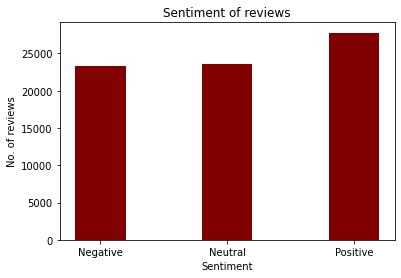

In [30]:
plt.bar(['Negative', 'Neutral', 'Positive'], counter, color ='maroon', width = 0.4) 
  
plt.xlabel("Sentiment")
plt.ylabel("No. of reviews")
plt.title("Sentiment of reviews")
plt.show()

Now data is better balanced.

# **4. Splitting dataset**

In [31]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(dataset['Text'], dataset['Sentiment'], test_size = 0.2)
train_x[:5]

1185     buying product year max would eat fast could g...
14185    great large small breeds fairly simple puzzle ...
24625    tea good package late flimsy box inside plasti...
6272     names juice drinks rarely really reflect major...
29482    amazon sucs tried email success stuck broken l...
Name: Text, dtype: object

In [32]:
# label encode the target variable 
label_encoder = preprocessing.LabelEncoder()
train_y = label_encoder.fit_transform(train_y)
valid_y = label_encoder.fit_transform(valid_y)
train_y[:5]

array([2, 2, 0, 2, 0])

# 5. Feature Extraction

> The next step is the feature extraction step. In this step, raw text data will be transformed into feature vectors and new features will be created using the existing dataset.


*   Count Vectors as features
*   TF-IDF Vectors as features

> 1.   Word level
2.   N-Gram level
3.   Character level

* Word Embeddings as features
* Text / NLP based features
* Topic Models as features



**5.1 Count Vectors as features**

In [33]:
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(dataset['Text'])

xtrain_count =  count_vect.transform(train_x)
xvalid_count =  count_vect.transform(valid_x)
#print(xtrain_count)

**5.2 TF-IDF Vectors as features**

In [34]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(dataset['Text'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(dataset['Text'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)

# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(dataset['Text'])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'token_pattern' will not be used"


**5.3 Word Embeddings**

> I have used GloVe embeddings as pretrained embeddings.   
*1 million word vectors trained on Wikipedia 2017, UMBC webbase corpus and statmt.org news dataset (16B tokens).*



In [35]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [36]:
!mkdir wiki-news-300d-1M
!unzip /content/drive/MyDrive/text_pretrain/wiki-news-300d-1M.vec.zip -d wiki-news-300d-1M

Archive:  /content/drive/MyDrive/text_pretrain/wiki-news-300d-1M.vec.zip
  inflating: wiki-news-300d-1M/wiki-news-300d-1M.vec  


In [37]:
embeddings_index = {}
for i, line in enumerate(open('wiki-news-300d-1M/wiki-news-300d-1M.vec')):
    values = line.split()
    embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')

In [39]:
# create a tokenizer 
from tensorflow.keras.preprocessing import text, sequence
token = text.Tokenizer()
token.fit_on_texts(dataset['Text'])
word_index = token.word_index
#word_index

In [40]:
# convert text to sequence of tokens and pad them to ensure equal length vectors 
train_seq_x = sequence.pad_sequences(token.texts_to_sequences(train_x), maxlen=80)
valid_seq_x = sequence.pad_sequences(token.texts_to_sequences(valid_x), maxlen=80)

In [41]:
# create token-embedding mapping
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# **6. Model building**


> The final step in the text classification framework is to train a classifier using the features created in the previous step. There are many different choices of machine learning models which can be used to train a final model.
* Naive Bayes Classifier
* Linear Classifier / Logistic Regression
* Support Vector Machine
* Random Forest Classifier
* Boosting Model
* Shallow Neural Networks
* Deep Neural Networks:
1. Convolutional Neural Network (CNN)
2. Long Short Term Modelr (LSTM) 
3. Gated Recurrent Unit (GRU) 
4. Bidirectional RNN 
5. Recurrent Convolutional Neural Network (RCNN)

The following function is a utility function which can be used to train a model. It accepts the classifier, feature_vector of training data, labels of training data and feature vectors of valid data as inputs. Using these inputs, the model is trained and accuracy score is computed.







In [42]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, valid_y)

# 6.1 Naive Bayes Classifier

In [43]:
# Naive Bayes on Count Vectors
accuracy_NB = [0]*4
accuracy_NB[0] = train_model(naive_bayes.MultinomialNB(), xtrain_count, train_y, xvalid_count)
print("Naive Bayes, Count Vectors:", round(accuracy_NB[0]*100,2), '%')

Naive Bayes, Count Vectors: 69.04 %


In [44]:
# Naive Bayes on Word Level TF IDF Vectors
accuracy_NB[1] = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xvalid_tfidf)
print("Naive Bayes, WordLevel TF-IDF:", round(accuracy_NB[1]*100,2), '%')

Naive Bayes, WordLevel TF-IDF: 68.6 %


In [45]:
# Naive Bayes on Ngram Level TF IDF Vectors
accuracy_NB[2] = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("Naive Bayes, N-gram TF-IDF:", round(accuracy_NB[2]*100,2), '%')

Naive Bayes, N-gram TF-IDF: 62.93 %


In [46]:
# Naive Bayes on Character Level TF IDF Vectors
accuracy_NB[3] = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("Naive Bayes, CharLevel vector:", round(accuracy_NB[3]*100,2), '%')

Naive Bayes, CharLevel vector: 63.73 %


In [47]:
accuracy_NB = [round(i*100,2) for i in accuracy_NB]

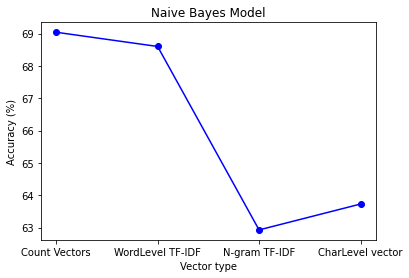

In [48]:
plot(['Count Vectors', 'WordLevel TF-IDF', 'N-gram TF-IDF', 'CharLevel vector'],accuracy_NB, 'Vector type', 'Accuracy (%)', 'Naive Bayes Model','-bo')

So, from above analysis we can say that Naive bayes performs best with Count vectors

# 6.2 Linear Classifier/ Logistic Regression

In [49]:
accuracy_LR = [0]*4

# Linear Classifier on Count Vectors
accuracy_LR[0] = train_model(linear_model.LogisticRegression(max_iter=1000), xtrain_count, train_y, xvalid_count)
print("Logistic Regression, Count Vectors:", round(accuracy_LR[0]*100,2), '%')

Logistic Regression, Count Vectors: 73.33 %


In [50]:
# Linear Classifier on Word Level TF IDF Vectors
accuracy_LR[1] = train_model(linear_model.LogisticRegression(max_iter=1000), xtrain_tfidf, train_y, xvalid_tfidf)
print("Logistic Regression, WordLevel TF-IDF:", round(accuracy_LR[1]*100,2), '%')

Logistic Regression, WordLevel TF-IDF: 72.24 %


In [51]:

# Linear Classifier on Ngram Level TF IDF Vectors
accuracy_LR[2] = train_model(linear_model.LogisticRegression(max_iter=1000), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("Logistic Regression, N-Gram Vectors:", round(accuracy_LR[2]*100,2), '%')

Logistic Regression, N-Gram Vectors: 63.69 %


In [52]:
# Linear Classifier on Character Level TF IDF Vectors
accuracy_LR[3] = train_model(linear_model.LogisticRegression(max_iter=1000), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("Logistic Regression, CharLevel Vectors:", round(accuracy_LR[3]*100,2), '%')

Logistic Regression, CharLevel Vectors: 68.66 %


In [53]:
accuracy_LR = [round(i*100,2) for i in accuracy_LR]

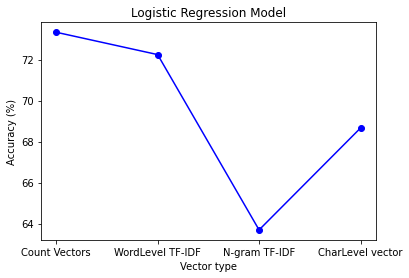

In [54]:
plot(['Count Vectors', 'WordLevel TF-IDF', 'N-gram TF-IDF', 'CharLevel vector'],accuracy_LR, 'Vector type', 'Accuracy (%)', 'Logistic Regression Model','-bo')

# 6.3 Support Vector Machine (SVM)

In [56]:
accuracy_SVM = [0]*4

# SVM on Count vectors
accuracy_SVM[0] = train_model(svm.LinearSVC(max_iter=20000), xtrain_count, train_y, xvalid_count)
print("SVM, Count Vectors:", round(accuracy_SVM[0]*100,2), '%')

SVM, Count Vectors: 71.25 %


In [57]:
# SVM on Word Level TF IDF Vectors
accuracy_SVM[1] = train_model(svm.LinearSVC(max_iter=20000), xtrain_tfidf, train_y, xvalid_tfidf)
print("SVM, WordLevel TF-IDF:", round(accuracy_SVM[1]*100,2), '%')

SVM, WordLevel TF-IDF: 71.41 %


In [58]:
# SVM on Ngram Level TF IDF Vectors
accuracy_SVM[2] = train_model(svm.LinearSVC(max_iter=20000), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("SVM, N-Gram Vectors: ", round(accuracy_SVM[2]*100,2), '%')

SVM, N-Gram Vectors:  63.19 %


In [59]:
# SVM on Character Level TF IDF Vectors
accuracy_SVM[3] = train_model(svm.LinearSVC(max_iter=20000), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("Logistic Regression, CharLevel Vectors:", round(accuracy_SVM[3]*100,2), '%')

Logistic Regression, CharLevel Vectors: 69.1 %


In [60]:
accuracy_SVM = [round(i*100,2) for i in accuracy_SVM]
accuracy_SVM

[71.25, 71.41, 63.19, 69.1]

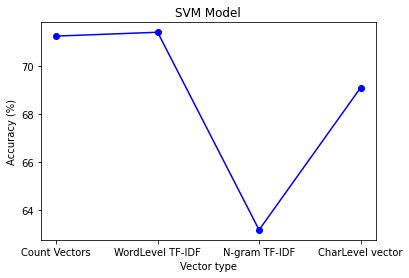

In [61]:

plot(['Count Vectors', 'WordLevel TF-IDF', 'N-gram TF-IDF', 'CharLevel vector'],accuracy_SVM, 'Vector type', 'Accuracy (%)', 'SVM Model','-bo')

# 6.4 Random Forest Classifier

In [70]:
accuracy_RF = [0]*4

In [72]:
# RF on Count Vectors
accuracy_RF[0] = train_model(ensemble.RandomForestClassifier(), xtrain_count, train_y, xvalid_count)
print("Random Forest, Count Vectors:", round(accuracy_RF[0]*100,2), '%')

Random Forest, Count Vectors: 73.35 %


In [73]:
# RF on Word Level TF IDF Vectors
accuracy_RF[1] = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf, train_y, xvalid_tfidf)
print("Random Forest, WordLevel TF-IDF:", round(accuracy_RF[1]*100,2), '%')


Random Forest, WordLevel TF-IDF: 72.63 %


In [74]:
# RF on N-gram Vectors
accuracy_RF[2] = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("Random Forest, N-Gram Vectors:", round(accuracy_RF[2]*100, 2), '%')

Random Forest, N-Gram Vectors: 65.13 %


In [75]:
# RF on Character Level TF IDF Vectors
accuracy_RF[3] = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("Random Forest, N-Gram Vectors:", round(accuracy_RF[3]*100, 2), '%')

Random Forest, N-Gram Vectors: 67.82 %


In [76]:
accuracy_RF = [round(i*100,2) for i in accuracy_RF]
accuracy_RF

[73.35, 72.63, 65.13, 67.82]

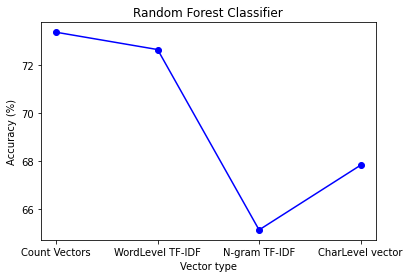

In [77]:
plot(['Count Vectors', 'WordLevel TF-IDF', 'N-gram TF-IDF', 'CharLevel vector'],accuracy_RF, 'Vector type', 'Accuracy (%)', 'Random Forest Classifier','-bo')

# 6.5 Boosting Model (XgBoost)

In [78]:
accuracy_XGB = [0]*4

In [79]:
# Extereme Gradient Boosting on Count Vectors
accuracy_XGB[0] = train_model(xgboost.XGBClassifier(), xtrain_count.tocsc(), train_y, xvalid_count.tocsc())
print("Xgb, Count Vectors:", round(accuracy_XGB[0]*100,2), '%')

Xgb, Count Vectors: 62.09 %


In [80]:
# Extereme Gradient Boosting on Word Level TF IDF Vectors
accuracy_XGB[1] = train_model(xgboost.XGBClassifier(), xtrain_tfidf.tocsc(), train_y, xvalid_tfidf.tocsc())
print("Xgb, WordLevel TF-IDF:", round(accuracy_XGB[1]*100,2),'%')

Xgb, WordLevel TF-IDF: 62.55 %


In [81]:
# Extereme Gradient Boosting on N-gram TF IDF Vectors
accuracy_XGB[2] = train_model(xgboost.XGBClassifier(), xtrain_tfidf_ngram_chars.tocsc(), train_y, xvalid_tfidf_ngram_chars.tocsc())
print('Xgb, N-gram TF-IDF vector:', round(accuracy_XGB[2]*100,2),'%')

Xgb, N-gram TF-IDF vector: 62.4 %


In [82]:
# Extereme Gradient Boosting on Character Level TF IDF Vectors
accuracy_XGB[3] = train_model(xgboost.XGBClassifier(), xtrain_tfidf_ngram_chars.tocsc(), train_y, xvalid_tfidf_ngram_chars.tocsc())
print('Xgb, Character vector TF-IDF vector:', round(accuracy_XGB[3]*100,2),'%')


Xgb, Character vector TF-IDF vector: 62.4 %


In [83]:
accuracy_XGB = [round(i*100,2) for i in accuracy_XGB]
accuracy_XGB

[62.09, 62.55, 62.4, 62.4]

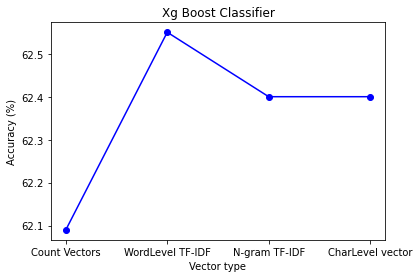

In [84]:
plot(['Count Vectors', 'WordLevel TF-IDF', 'N-gram TF-IDF', 'CharLevel vector'],accuracy_XGB, 'Vector type', 'Accuracy (%)', 'Xg Boost Classifier','-bo')

Let's compare all the models

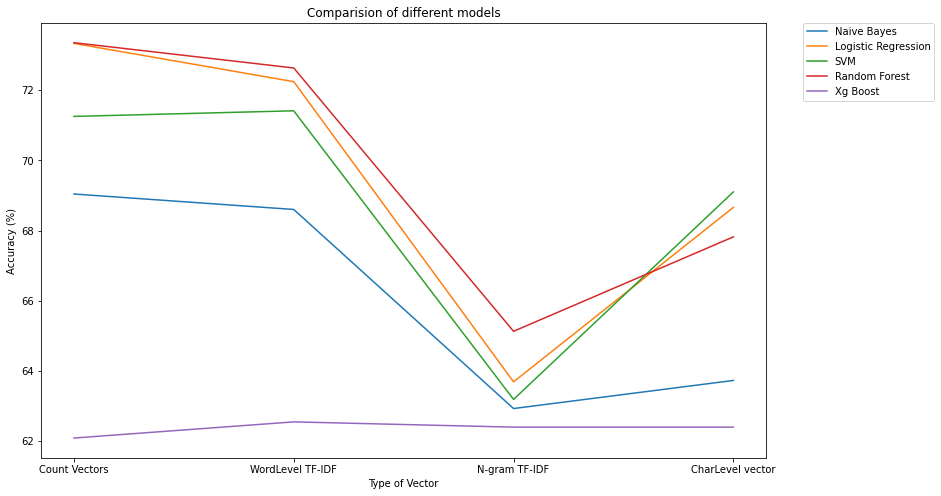

In [85]:
plt.figure(figsize=[13, 8])
plt.plot(['Count Vectors', 'WordLevel TF-IDF', 'N-gram TF-IDF', 'CharLevel vector'], accuracy_NB, label = 'Naive Bayes')
plt.plot(['Count Vectors', 'WordLevel TF-IDF', 'N-gram TF-IDF', 'CharLevel vector'], accuracy_LR, label = 'Logistic Regression')
plt.plot(['Count Vectors', 'WordLevel TF-IDF', 'N-gram TF-IDF', 'CharLevel vector'], accuracy_SVM, label = 'SVM')
plt.plot(['Count Vectors', 'WordLevel TF-IDF', 'N-gram TF-IDF', 'CharLevel vector'], accuracy_RF, label = 'Random Forest')
plt.plot(['Count Vectors', 'WordLevel TF-IDF', 'N-gram TF-IDF', 'CharLevel vector'], accuracy_XGB, label = 'Xg Boost')
plt.title('Comparision of different models')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Type of Vector')
plt.ylabel('Accuracy (%)')
plt.show()

# 6.6 Shallow Neural Networks

In [86]:
from tensorflow.keras import layers, models, optimizers
from tensorflow import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from keras.layers.core import Activation
from tensorflow.keras.layers import Input, Flatten, Embedding, LSTM, Dropout, Dense, GlobalMaxPooling1D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import plot_model
from IPython.display import display, Image
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from tensorflow.keras.callbacks import EarlyStopping

In [87]:
X = list(dataset['Text'])
Y = LabelBinarizer().fit_transform(dataset.Sentiment)
x = 1
dataset['Sentiment'][x], Y[x]

('negative', array([1, 0, 0]))

In [88]:
train_x, test_x, train_y, test_y = model_selection.train_test_split(X, Y, test_size = 0.2)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dataset['Text'])

In [89]:
train_x = tokenizer.texts_to_sequences(train_x)
test_x = tokenizer.texts_to_sequences(test_x)

In [90]:
vocab_size = len(tokenizer.word_index) + 1
maxlen = 80
train_x = pad_sequences(train_x, padding='post', maxlen=maxlen, truncating='post')
test_x = pad_sequences(test_x, padding='post', maxlen=maxlen, truncating='post')
train_x[0]

array([  78,    6,  239,   36,  469,  144,    7,    3,   31,  218, 1427,
         36,    7, 2628,  246,   44,  650,   27,  294, 1333,   36,  691,
         18,  420, 7572,  709,  283,  499,  391,  171,  196,   40,  613,
          5,  499,  184,   67,  182,  332,  458,   31, 2201,  364,   30,
       3150,   72,  289,   34,  118,   73,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0], dtype=int32)

In [139]:
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
history = []
scores = []
loss_type = 'binary_crossentropy'
accuracy_type = 'categorical_accuracy'

In [140]:
def print_model_architecture(model, name):
  plot_model(model, to_file=name+'.png', show_shapes=True, show_layer_names=True)
  display(Image(filename=name+'.png'))

In [141]:
def get_score(model):
  score = model.evaluate(test_x, test_y, verbose=1)
  print("Test Score:", score[0])
  print("Test Accuracy:", score[1])
  return score

In [142]:
def plot_results(history):
  plt.plot(history.history[accuracy_type])
  plt.plot(history.history['val_'+accuracy_type])

  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])

  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  plt.show()

In [143]:
def shallow_NN(input_size):
    # create input layer 
    input_layer = layers.Input((input_size, ), sparse=True)
    
    # create hidden layer
    hidden_layer = layers.Dense(128, activation="relu")(input_layer)
    
    # create output layer
    output_layer = layers.Dense(3, activation="sigmoid")(hidden_layer)

    classifier = models.Model(inputs = input_layer, outputs = output_layer)
    classifier.compile(optimizer=optimizers.Adam(), loss=loss_type, metrics = [accuracy_type])
    
    return classifier

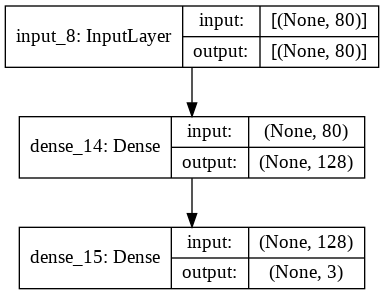

In [144]:
shallow_NN = shallow_NN(maxlen)
print_model_architecture(shallow_NN, 'shallow_NN')

In [145]:
history_shallow = shallow_NN.fit(train_x, train_y, epochs=10, verbose=1, validation_split=0.2, callbacks=[es])
history.append(history_shallow)

Epoch 1/10
1494/1494 [==============================] - 3s 2ms/step - loss: 198.4565 - categorical_accuracy: 0.3428 - val_loss: 48.8796 - val_categorical_accuracy: 0.3355
Epoch 2/10
1494/1494 [==============================] - 2s 2ms/step - loss: 29.2224 - categorical_accuracy: 0.3645 - val_loss: 11.3825 - val_categorical_accuracy: 0.3197
Epoch 3/10
1494/1494 [==============================] - 2s 1ms/step - loss: 8.0176 - categorical_accuracy: 0.3466 - val_loss: 5.4438 - val_categorical_accuracy: 0.3302
Epoch 4/10
1494/1494 [==============================] - 2s 1ms/step - loss: 3.7306 - categorical_accuracy: 0.3475 - val_loss: 2.3405 - val_categorical_accuracy: 0.3297
Epoch 5/10
1494/1494 [==============================] - 2s 1ms/step - loss: 1.7589 - categorical_accuracy: 0.3455 - val_loss: 1.1130 - val_categorical_accuracy: 0.3660
Epoch 6/10
1494/1494 [==============================] - 2s 1ms/step - loss: 0.9422 - categorical_accuracy: 0.3549 - val_loss: 0.7212 - val_categorical_accu

In [146]:
scores.append(get_score(shallow_NN))

467/467 [==============================] - 0s 861us/step - loss: 0.6435 - categorical_accuracy: 0.3714
Test Score: 0.6435070633888245
Test Accuracy: 0.3713597059249878


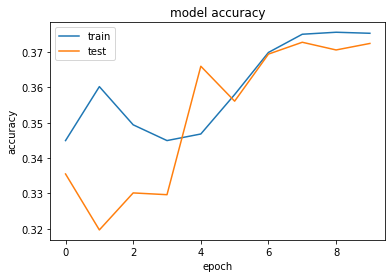

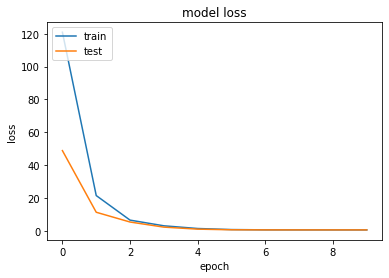

In [147]:
plot_results(history[0])

# 6.7 Deep Neural Networks

> **6.7.1 Convolutional Neural Network**



In [148]:
def cnn(input_length, prior = True):
    # Add an Input Layer
    input_layer = layers.Input((input_length, ))

    # Add the word embedding Layer
    if prior:
      embedding_layer = layers.Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=True)(input_layer)
    else:
      embedding_layer = layers.Embedding(vocab_size, 300, trainable=True)(input_layer)
    
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the convolutional Layer
    conv_layer = layers.Convolution1D(128, 3, activation="relu")(embedding_layer)

    # Add the pooling Layer
    pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(64, activation="relu")(pooling_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(3, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss=loss_type, metrics = [accuracy_type])
    
    return model

without prior

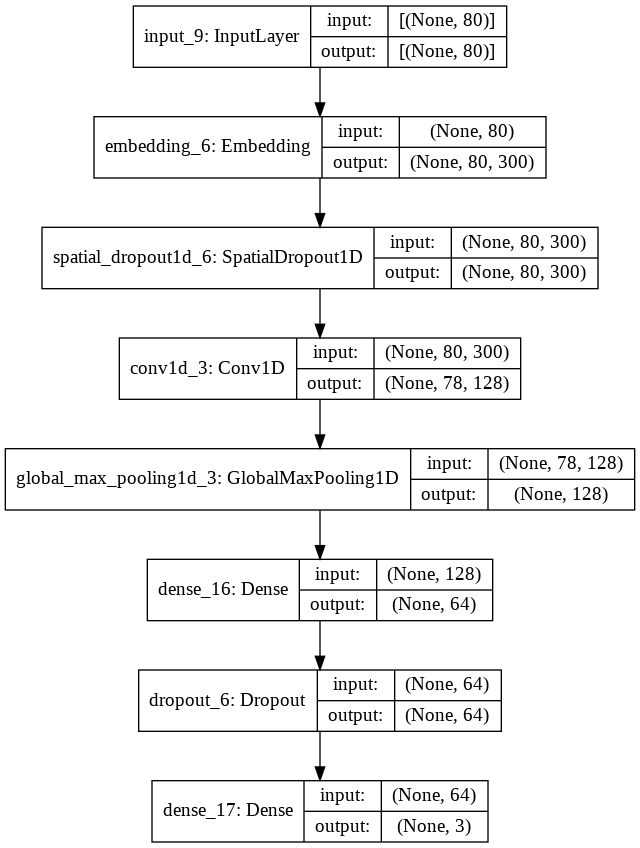

In [149]:
cnn_classifier_without_prior = cnn(maxlen, False)
print_model_architecture(cnn_classifier_without_prior, 'cnn_classifier_1')

In [150]:
history_cnn_1 = cnn_classifier_without_prior.fit(train_x, train_y, epochs=10, verbose=1, validation_split=0.2, callbacks=[es])
history.append(history_cnn_1)

Epoch 1/10
1494/1494 [==============================] - 295s 197ms/step - loss: 0.5201 - categorical_accuracy: 0.5795 - val_loss: 0.4009 - val_categorical_accuracy: 0.7152
Epoch 2/10
1494/1494 [==============================] - 294s 197ms/step - loss: 0.3250 - categorical_accuracy: 0.7912 - val_loss: 0.3911 - val_categorical_accuracy: 0.7270
Epoch 3/10
1494/1494 [==============================] - 346s 232ms/step - loss: 0.1980 - categorical_accuracy: 0.8882 - val_loss: 0.4452 - val_categorical_accuracy: 0.7304


467/467 [==============================] - 7s 15ms/step - loss: 0.4372 - categorical_accuracy: 0.7365
Test Score: 0.43716365098953247
Test Accuracy: 0.7364932894706726


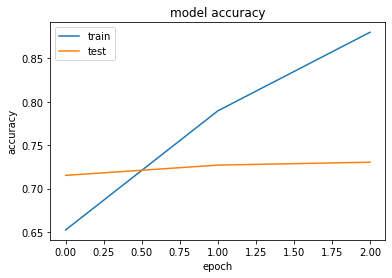

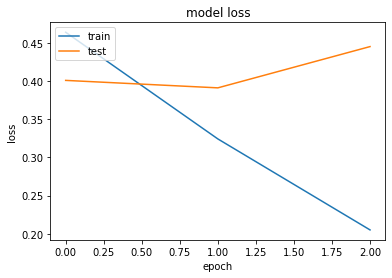

In [151]:
scores.append(get_score(cnn_classifier_without_prior))
plot_results(history[1])

With Prior of embedding matrix

In [152]:
cnn_classifier_with_prior = cnn(maxlen)
history_cnn_2 = cnn_classifier_with_prior.fit(train_x, train_y, epochs=10, verbose=1, validation_split=0.2, callbacks=[es])
history.append(history_cnn_2)

Epoch 1/10
1494/1494 [==============================] - 365s 243ms/step - loss: 0.5171 - categorical_accuracy: 0.5780 - val_loss: 0.3977 - val_categorical_accuracy: 0.7176
Epoch 2/10
1494/1494 [==============================] - 330s 221ms/step - loss: 0.3368 - categorical_accuracy: 0.7785 - val_loss: 0.3790 - val_categorical_accuracy: 0.7338
Epoch 3/10
1494/1494 [==============================] - 336s 225ms/step - loss: 0.2262 - categorical_accuracy: 0.8634 - val_loss: 0.4076 - val_categorical_accuracy: 0.7367


467/467 [==============================] - 7s 15ms/step - loss: 0.4044 - categorical_accuracy: 0.7405
Test Score: 0.4044184982776642
Test Accuracy: 0.7405101656913757


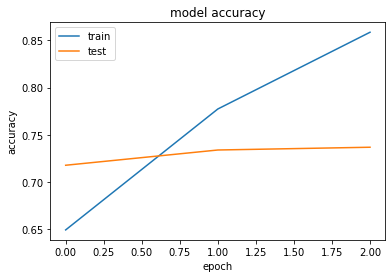

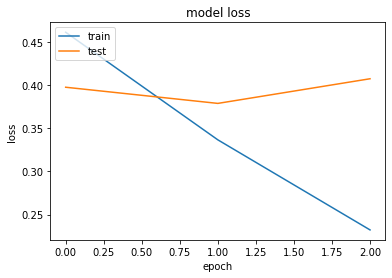

In [153]:
scores.append(get_score(cnn_classifier_with_prior))
plot_results(history[2])


> **3.7.2 Recurrent Neural Network – LSTM**



In [154]:
def rnn_lstm(input_length):
  # Add an Input Layer
  input_layer = layers.Input((input_length, ))

  # Add the word embedding Layer
  embedding_layer = layers.Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=True)(input_layer)
  embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

  # Add the LSTM Layer
  lstm_layer = layers.LSTM(128)(embedding_layer)

  # Add the output Layers
  output_layer1 = layers.Dense(128, activation="relu")(lstm_layer)
  output_layer1 = layers.Dropout(0.25)(output_layer1)
  output_layer2 = layers.Dense(3, activation="sigmoid")(output_layer1)

  # Compile the model
  model = models.Model(inputs=input_layer, outputs=output_layer2)
  model.compile(optimizer=optimizers.Adam(), loss=loss_type, metrics=[accuracy_type])
  
  return model

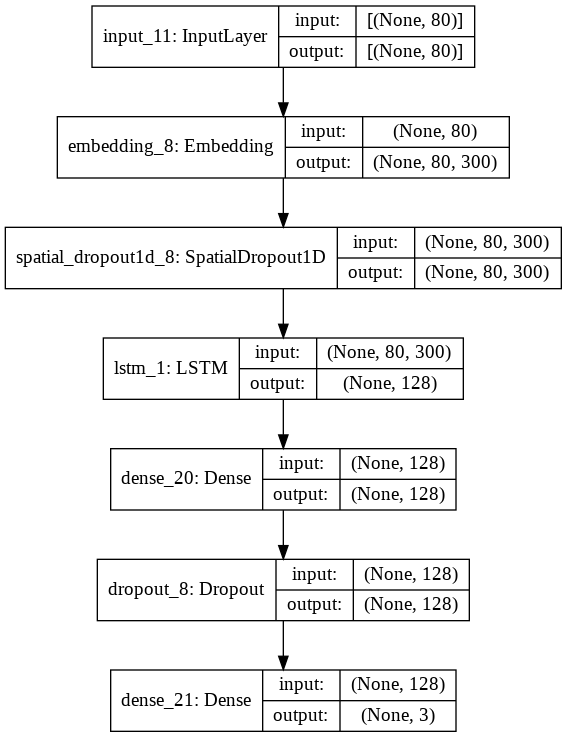

In [155]:
rnn_lstm_classifier = rnn_lstm(maxlen)
print_model_architecture(rnn_lstm_classifier, 'rnn_lstm_classifier')

In [156]:
history_rnn_lstm = rnn_lstm_classifier.fit(train_x, train_y, epochs=10, verbose=1, validation_split=0.2, callbacks=[es])
history.append(history_rnn_lstm)

Epoch 1/10
1494/1494 [==============================] - 544s 363ms/step - loss: 0.6341 - categorical_accuracy: 0.3913 - val_loss: 0.6297 - val_categorical_accuracy: 0.4013
Epoch 2/10
1494/1494 [==============================] - 510s 341ms/step - loss: 0.6018 - categorical_accuracy: 0.4507 - val_loss: 0.4304 - val_categorical_accuracy: 0.6892
Epoch 3/10
1494/1494 [==============================] - 515s 345ms/step - loss: 0.3800 - categorical_accuracy: 0.7370 - val_loss: 0.3942 - val_categorical_accuracy: 0.7313
Epoch 4/10
1494/1494 [==============================] - 578s 387ms/step - loss: 0.2728 - categorical_accuracy: 0.8304 - val_loss: 0.4161 - val_categorical_accuracy: 0.7353


467/467 [==============================] - 23s 50ms/step - loss: 0.4160 - categorical_accuracy: 0.7299
Test Score: 0.4159819185733795
Test Accuracy: 0.7298654317855835


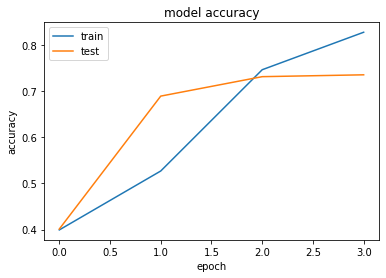

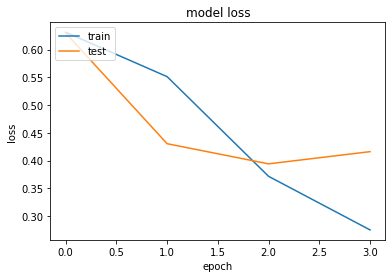

In [157]:
scores.append(get_score(rnn_lstm_classifier))
plot_results(history[3])



> **3.7.3 Recurrent Neural Network – GRU**



In [158]:
def rnn_gru(input_length):
  # Add an Input Layer
  input_layer = layers.Input((input_length, ))

  # Add the word embedding Layer
  embedding_layer = layers.Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=True)(input_layer)
  embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

  # Add the GRU Layer
  lstm_layer = layers.GRU(128)(embedding_layer)

  # Add the output Layers
  output_layer1 = layers.Dense(128, activation="relu")(lstm_layer)
  output_layer1 = layers.Dropout(0.25)(output_layer1)
  output_layer2 = layers.Dense(3, activation="sigmoid")(output_layer1)

  # Compile the model
  model = models.Model(inputs=input_layer, outputs=output_layer2)
  model.compile(optimizer=optimizers.Adam(), loss=loss_type, metrics=[accuracy_type])
  
  return model

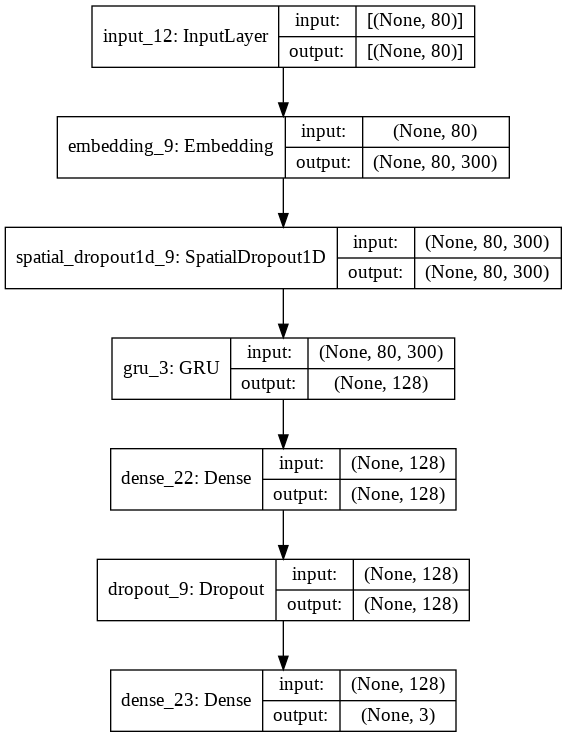

In [159]:
rnn_gru_classifier = rnn_gru(maxlen)
print_model_architecture(rnn_gru_classifier, 'rnn_gru_classifier')

In [160]:
history_rnn_gru = rnn_gru_classifier.fit(train_x, train_y, epochs=10, verbose=1, validation_split=0.2, callbacks=[es])
history.append(history_rnn_gru)

Epoch 1/10
1494/1494 [==============================] - 443s 295ms/step - loss: 0.6367 - categorical_accuracy: 0.3843 - val_loss: 0.6276 - val_categorical_accuracy: 0.4018
Epoch 2/10
1494/1494 [==============================] - 417s 279ms/step - loss: 0.5046 - categorical_accuracy: 0.5893 - val_loss: 0.3855 - val_categorical_accuracy: 0.7324
Epoch 3/10
1494/1494 [==============================] - 426s 285ms/step - loss: 0.3019 - categorical_accuracy: 0.8029 - val_loss: 0.3862 - val_categorical_accuracy: 0.7383


467/467 [==============================] - 13s 29ms/step - loss: 0.3844 - categorical_accuracy: 0.7346
Test Score: 0.38436001539230347
Test Accuracy: 0.7345517873764038


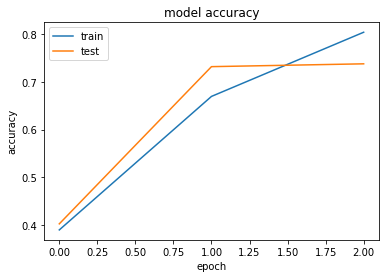

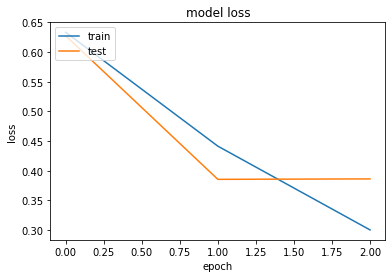

In [161]:
scores.append(get_score(rnn_gru_classifier))
plot_results(history[4])



> **3.7.4 Bidirectional RNN**



In [162]:
def bidirectional_rnn(input_length):
  # Add an Input Layer
  input_layer = layers.Input((input_length, ))

  # Add the word embedding Layer
  embedding_layer = layers.Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=True)(input_layer)
  embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

  # Add the LSTM Layer
  lstm_layer = layers.Bidirectional(layers.GRU(128))(embedding_layer)

  # Add the output Layers
  output_layer1 = layers.Dense(128, activation="relu")(lstm_layer)
  output_layer1 = layers.Dropout(0.25)(output_layer1)
  output_layer2 = layers.Dense(3, activation="sigmoid")(output_layer1)

  # Compile the model
  model = models.Model(inputs=input_layer, outputs=output_layer2)
  model.compile(optimizer=optimizers.Adam(), loss=loss_type, metrics=[accuracy_type])
  
  return model

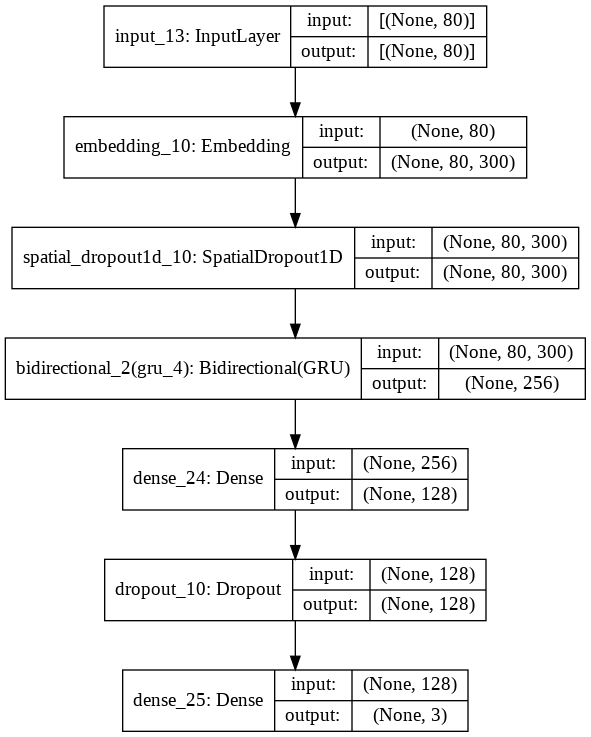

In [163]:
bidirectional_rnn_classifier = bidirectional_rnn(maxlen)
print_model_architecture(bidirectional_rnn_classifier, 'bidirectional_rnn_classifier')

In [164]:
history_bidirectional_rnn = bidirectional_rnn_classifier.fit(train_x, train_y, epochs=10, verbose=1, validation_split=0.2, callbacks=[es])
history.append(history_bidirectional_rnn)

Epoch 1/10
1494/1494 [==============================] - 622s 414ms/step - loss: 0.5101 - categorical_accuracy: 0.5829 - val_loss: 0.3915 - val_categorical_accuracy: 0.7284
Epoch 2/10
1494/1494 [==============================] - 616s 413ms/step - loss: 0.3216 - categorical_accuracy: 0.7877 - val_loss: 0.3852 - val_categorical_accuracy: 0.7331
Epoch 3/10
1494/1494 [==============================] - 645s 432ms/step - loss: 0.2175 - categorical_accuracy: 0.8684 - val_loss: 0.4322 - val_categorical_accuracy: 0.7330


467/467 [==============================] - 23s 48ms/step - loss: 0.4314 - categorical_accuracy: 0.7284
Test Score: 0.4314222037792206
Test Accuracy: 0.7283926010131836


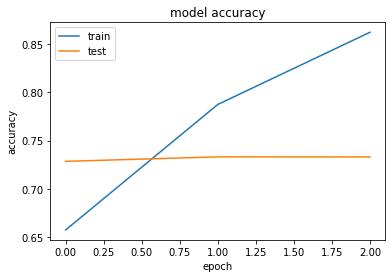

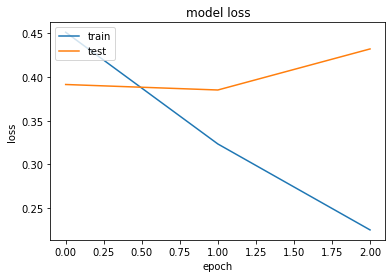

In [165]:
scores.append(get_score(bidirectional_rnn_classifier))
plot_results(history[5])



> **3.7.5 Recurrent Convolutional Neural Network**



In [166]:
def rcnn(input_length):
  # Add an Input Layer
  input_layer = layers.Input((input_length, ))

  # Add the word embedding Layer
  embedding_layer = layers.Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=True)(input_layer)
  embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)
  
  # Add the recurrent layer
  rnn_layer = layers.Bidirectional(layers.GRU(128, return_sequences=True))(embedding_layer)
  
  # Add the convolutional Layer
  conv_layer = layers.Convolution1D(128, 3, activation="relu")(embedding_layer)

  # Add the pooling Layer
  pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

  # Add the output Layers
  output_layer1 = layers.Dense(128, activation="relu")(pooling_layer)
  output_layer1 = layers.Dropout(0.25)(output_layer1)
  output_layer2 = layers.Dense(3, activation="sigmoid")(output_layer1)

  # Compile the model
  model = models.Model(inputs=input_layer, outputs=output_layer2)
  model.compile(optimizer=optimizers.Adam(), loss=loss_type, metrics = [accuracy_type])
  
  return model

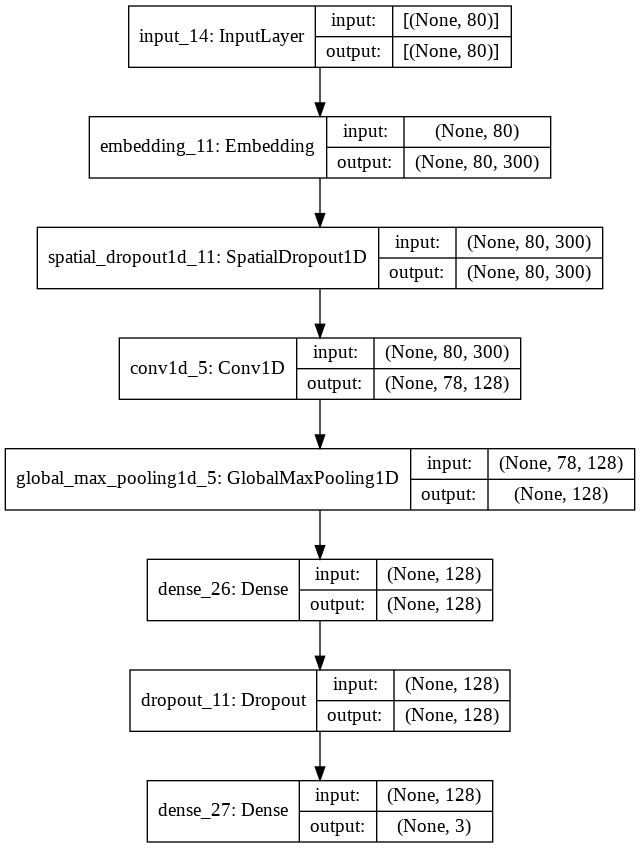

In [167]:
rcnn_classifier = rcnn(maxlen)
print_model_architecture(rcnn_classifier, 'rcnn_classifier')

In [168]:
history_rcnn = rcnn_classifier.fit(train_x, train_y, epochs=10, verbose=1, validation_split=0.2, callbacks=[es])
history.append(history_rcnn)

Epoch 1/10
1494/1494 [==============================] - 292s 195ms/step - loss: 0.5134 - categorical_accuracy: 0.5810 - val_loss: 0.3934 - val_categorical_accuracy: 0.7245
Epoch 2/10
1494/1494 [==============================] - 291s 195ms/step - loss: 0.3288 - categorical_accuracy: 0.7852 - val_loss: 0.3888 - val_categorical_accuracy: 0.7341
Epoch 3/10
1494/1494 [==============================] - 289s 193ms/step - loss: 0.2115 - categorical_accuracy: 0.8742 - val_loss: 0.4146 - val_categorical_accuracy: 0.7419


467/467 [==============================] - 6s 13ms/step - loss: 0.4135 - categorical_accuracy: 0.7491
Test Score: 0.41347891092300415
Test Accuracy: 0.7490794658660889


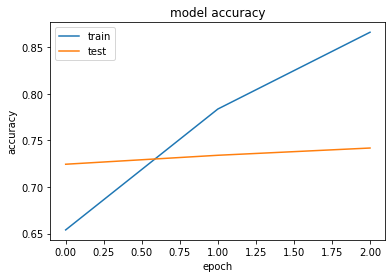

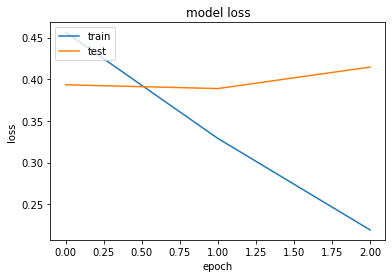

In [169]:
scores.append(get_score(rcnn_classifier))
plot_results(history[6])

# 7. Comparative analysis of all the Neural Networks

In [170]:
test_accuracy = [round(i[1]*100,2) for i in scores]
model_list = ['Shallow NN', 'CNN (without prior)', 'CNN (with prior)', 'RNN - LSTM', 'RNN - GRU', 'Bidirectional RNN', 'RCNN']

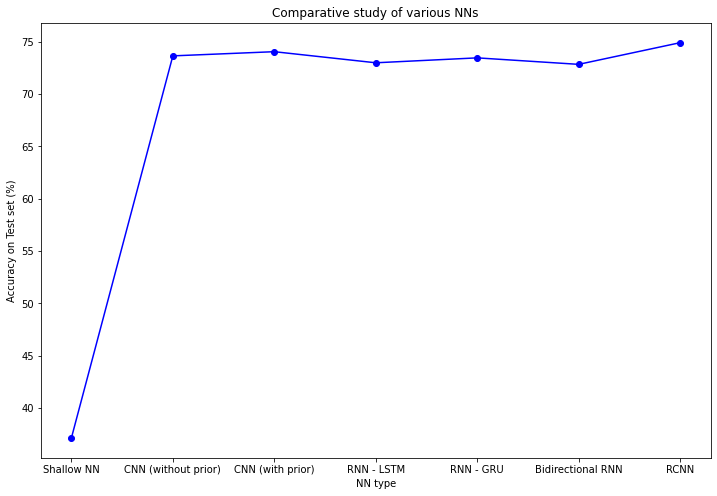

In [171]:
plt.figure(figsize=[12,8])
plt.plot(model_list, test_accuracy, '-bo')
plt.xlabel('NN type')
plt.ylabel('Accuracy on Test set (%)')
plt.title('Comparative study of various NNs')
plt.show()